# **Deep Neural Network con Keras**

En este ejercicio se procede a realizar una Deep Neural Network con el Framework Keras, utilizando Tensorflow como Backend. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Input, Dense, BatchNormalization, Add, GaussianNoise, Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.layers import Wrapper
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras import regularizers
import matplotlib.pyplot as plt
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


# 0. Funciones auxiliares.

In [3]:
precisiones_globales=[]
epochs = 15
def graf_model(train_history):
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    # summarize history for accuracy
    ax.plot(train_history.history['binary_accuracy'])
    ax.plot(train_history.history['val_binary_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(train_history.history['loss'])
    ax2.plot(train_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()
def precision(model, registrar=False):
    y_pred = model.predict(train_dfX)
    train_auc = roc_auc_score(train_dfY, y_pred)
    y_pred = model.predict(val_dfX)
    val_auc = roc_auc_score(val_dfY, y_pred)
    print('Train AUC: ', train_auc)
    print('Vali AUC: ', val_auc)
    if registrar:
        precisiones_globales.append([train_auc,val_auc])


# 1. Importando los datos:
Se procede a leer tanto el train.csv que es el conjunto de entrenamiento como el test.csv que es el conjunto de validacion. Mas adelante se construira en base a train.csv el conjunto de dev

In [4]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (200000, 202)
Test shape :  (200000, 201)


Se crea las variables X y Y con las que se van a entrenar al modelo.
Tambien se elimina el ID_Code ya que no aporta valor al entrenamiento del modelo. 

In [5]:
train_dfX = train_df.drop(['ID_code', 'target'], axis=1)
train_dfY = train_df['target']
submission = test_df[['ID_code']].copy()
test_df = test_df.drop(['ID_code'], axis=1)


# 2. Normalizando los valores de X
Se transforma X de manera que quede normalizado todos su valores.

In [6]:
sc = StandardScaler()
train_dfX = sc.fit_transform(train_dfX)
test_df = sc.transform(test_df)

# 3. Separando Entrenamiento de Validacion
Se divide X para tener un conjunto de entrenamiento y otro de validacion y pruebas. El 90% de las observaciones quedan en el conjunto de entrenamiento.

In [7]:
train_dfX,val_dfX,train_dfY, val_dfY = train_test_split(train_dfX,train_dfY , test_size=0.1, stratify=train_dfY)
print("Entrnamiento: ",train_dfX.shape)
print("Validacion : ",val_dfX.shape)

Entrnamiento:  (180000, 200)
Validacion :  (20000, 200)


Aqui podemos ver como nuestra variable de entramiento train_dfX tiene 16200 observaciones y 200 caracteristicas. Es decir, la forma en la que ingresaremos datos a nuestro modelo sera (200, )

# 4. Creacion del modelo.


Vamos a definir una funcion que cree un modelo de red neuronal. Esta red va a tener 2 capaz ocultas con 1028 neuronas cada una. Se va a utilizar el optimizador SGD y la funcion de costo BinaryCrossEntropy. Los valores W del modelo se iniciaran de manera aleatoria y uniforme, los valores de b se iniciaran en cero.

A tener en cuenta:

Cual es el learning Rate de este modelo?


In [8]:
def func_model():   
    inp = Input(shape=(200,))
    x=Dense(1028, activation="relu", kernel_initializer='random_uniform', bias_initializer='zeros')(inp)
    x=Dense(1028, activation="relu", kernel_initializer='random_uniform', bias_initializer='zeros')(x) 
    x=Dense(1, activation="sigmoid", kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['binary_accuracy'])
    return model
model = func_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1028)              206628    
_________________________________________________________________
dense_2 (Dense)              (None, 1028)              1057812   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1029      
Total params: 1,265,469
Trainable params: 1,265,469
Non-trainable params: 0
_________________________________________________________________
None


# 5. Entrenamiento del modelo.

Se entrenara el modelo con un batch_size de 512. Utilizando nuestras variables de validacion para seguir de cerca el accuracy tanto en entrenamiento como en validacion. Esto lo haremos por 20 epochs.

In [9]:
train_history = model.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY))


Instructions for updating:
Use tf.cast instead.
Train on 180000 samples, validate on 20000 samples
Epoch 1/15
180000/180000 [==============================] - 4s 25us/step - loss: 0.3378 - binary_accuracy: 0.8987 - val_loss: 0.3206 - val_binary_accuracy: 0.8995
Epoch 2/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.3118 - binary_accuracy: 0.8995 - val_loss: 0.3047 - val_binary_accuracy: 0.8995
Epoch 3/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.2949 - binary_accuracy: 0.8995 - val_loss: 0.2879 - val_binary_accuracy: 0.8995
Epoch 4/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.2773 - binary_accuracy: 0.8996 - val_loss: 0.2710 - val_binary_accuracy: 0.8998
Epoch 5/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.2611 - binary_accuracy: 0.9014 - val_loss: 0.2574 - val_binary_accuracy: 0.9030
Epoch 6/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.2495 - b

Vamos a ver una grafica de como se comporta nuestro modelo tanto en la perdida como en la precision (binary_accuracy).

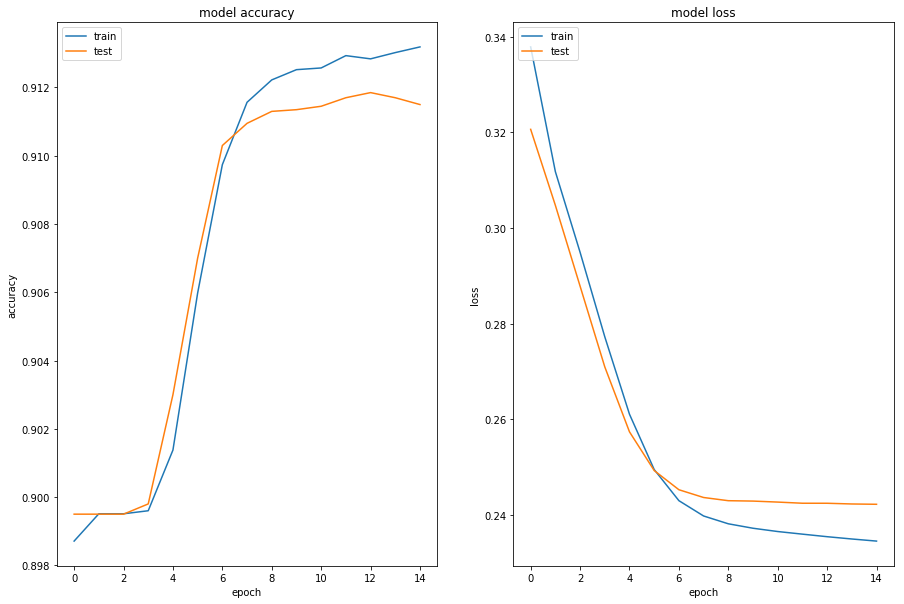

In [10]:
graf_model(train_history)

# 6. Precision del modelo.

En esta competencia la metrica utilizada para medir la precision de nuestro modelo es el AUC (referencia rapida: https://es.wikipedia.org/wiki/Curva_ROC). Por lo que vamos a estar bastante enfocados en mejorarla. 

La funcion precision() nos va a permitir, dado como parametro uno de nuestros modelos, imprimir el valor de AUC tanto del conjunto de entrenamiento como del de validacion. 

In [11]:
precision(model, True)

Train AUC:  0.857630573854349
Vali AUC:  0.8430124806761081


# 7. Tamaño de la Red. (Evaluado)

En este apartado vamos a estar revisando como el tamaño de la red afecta el desempeño de la misma. Vamos a experimentar utilizando distinta cantidad de capaz ocultas y de neuronas por capa.

La variable arquitectura es una lista de Python que sirve como parametro de la funcion model(arquitectura) para definir una red neuronal con una cantidad len(arquitectura) de capaz ocultas, donde cada capa oculta l tiene una cantidad de neuronas arquitectura[l-1].

Por ejemplo, de configurar la variable arquitectura  de forma [5,10,20] tendremos una red neuronal con 3 capaz ocultas, con 5, 10 y 20 capaz respectivamente. 

In [13]:
def func_model(arquitectura): 
    first =True
    inp = Input(shape=(200,))
    for capa in arquitectura:        
        if first:
            x=Dense(capa, activation="relu", kernel_initializer='random_uniform', bias_initializer='zeros')(inp)            
            first = False
        else:
            x=Dense(capa, activation="relu", kernel_initializer='random_uniform', bias_initializer='zeros')(x)  
    x=Dense(1, activation="sigmoid", kernel_initializer='random_uniform', bias_initializer='zeros')(x)  
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['binary_accuracy'])
    return model

# Experimento 1

Juega con distintos tamaños de red para ver como esto afecta el desempeño del modelo (Vas a poder ver el impacto en las graficas de perdida, binary_accuracy y valor de AUC)

Vas a poder comparar valores utilizando el Experimento 1 y 2 al mismo tiempo.

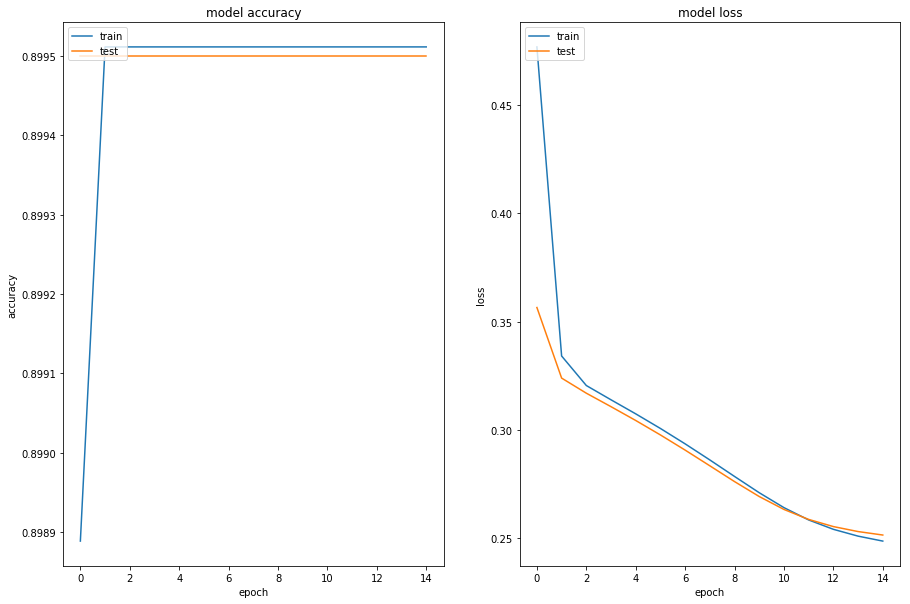

Train AUC:  0.852124155026393
Vali AUC:  0.8430869969220048


In [30]:
arquitectura1 = [100,100]
model1 = func_model(arquitectura1)
#Para revisar la estructura del modelo, quitar el comentario de la instruccion siguiente:
#=print(model1.summary())
train_history_tam1 = model1.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY), verbose=0)
graf_model(train_history_tam1)
precision(model1)

# Experimento 2

Train on 180000 samples, validate on 20000 samples
Epoch 1/15
180000/180000 [==============================] - 2s 10us/step - loss: 0.5222 - binary_accuracy: 0.8979 - val_loss: 0.4215 - val_binary_accuracy: 0.8995
Epoch 2/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.3840 - binary_accuracy: 0.8995 - val_loss: 0.3591 - val_binary_accuracy: 0.8995
Epoch 3/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.3476 - binary_accuracy: 0.8995 - val_loss: 0.3393 - val_binary_accuracy: 0.8995
Epoch 4/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.3350 - binary_accuracy: 0.8995 - val_loss: 0.3319 - val_binary_accuracy: 0.8995
Epoch 5/15
180000/180000 [==============================] - 2s 8us/step - loss: 0.3301 - binary_accuracy: 0.8995 - val_loss: 0.3288 - val_binary_accuracy: 0.8995
Epoch 6/15
180000/180000 [==============================] - 2s 9us/step - loss: 0.3280 - binary_accuracy: 0.8995 - val_loss: 0.3274 - val_

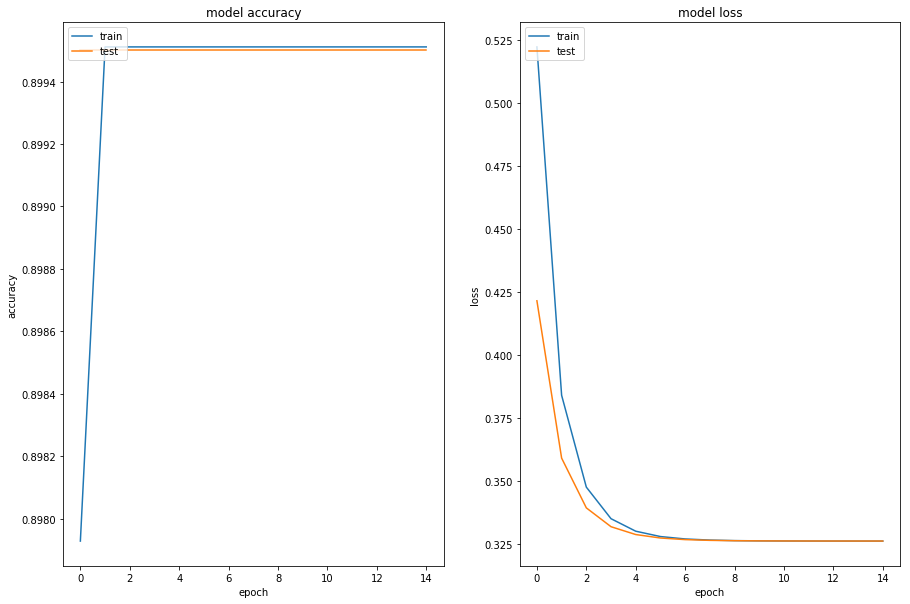

Train AUC:  0.47670379871635243
Vali AUC:  0.47914156289149024


In [18]:
arquitectura2 = [10,10,10]
model2 = func_model(arquitectura2)
#print(model2.summary())
train_history_tam2 = model2.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY))
graf_model(train_history_tam2)
precision(model2)

# Resultado Final

Elije una arquitectura de red que te permita tener el valor de AUC mas alto que puedas lograr

 **Ejecuta esta celda 1 sola vez con la arquitectura final elegida en los experimentos anteriores**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_56 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 180000 samples, validate on 20000 samples
Epoch 1/15
180000/180000 [==============================] - 2s 13us/step - loss: 0.4772 - binary_accuracy: 0.8985 - val_loss: 0.3558 - val_binary_accuracy: 0.8995
Epoch 2/15
180000/180000 [=========================

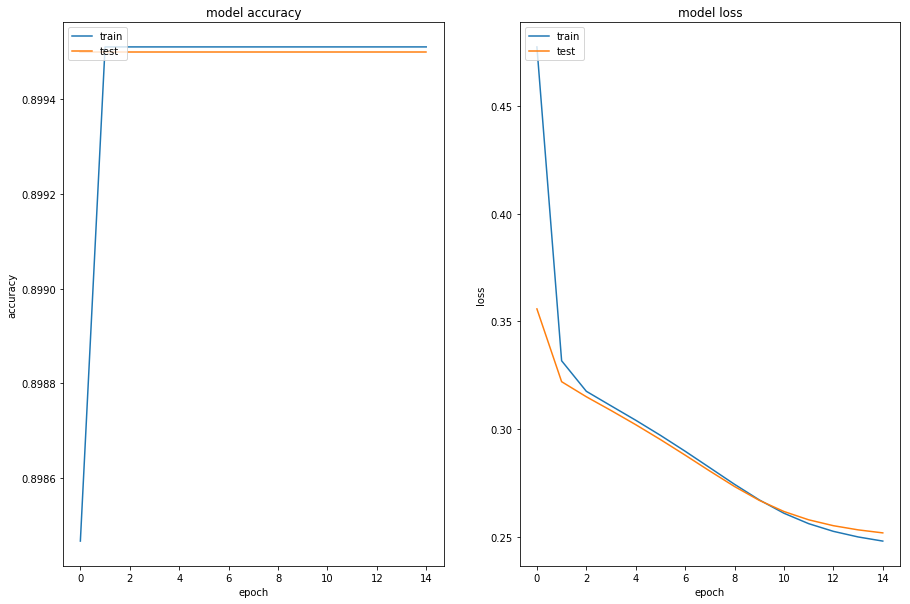

Train AUC:  0.852429920188161
Vali AUC:  0.8415379190761038


In [31]:
arquitecturaFinal = [100,100]
modelF = func_model(arquitecturaFinal)
print(modelF.summary())
train_history_tamF = modelF.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY))
graf_model(train_history_tamF)
precision(modelF, True)
assert(len(precisiones_globales)==2)

# 7. Regularizacion de la Red. (Evaluado)

En el siguiente ejercicio vamos a experimentar con la regularizacion de nuestra red. La idea es que basado en la arquitectura "optima" que consiguieron en el apartado anterior empecemos a mejorar nuestro modelo. 

Vamos a experimentar con distintos valores para el P del DropOut y aplicando o no regularizacion L2 en las distintas capas. Para agregar regularizacion L2 a una capa se debe colocar regularizers.l2(0.01) como parametro en kernel_regularizer.

In [47]:
def func_model_reg():   
    inp = Input(shape=(200,))
    x=Dropout(0)(inp)
    x=Dense(1028, activation="relu",  bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01))(x)
    x=Dropout(0)(x)
    x=Dense(1028, activation="relu",  bias_initializer='zeros', kernel_regularizer=regularizers.l2(0.01))(x)
    x=Dropout(0)(x)
    x=Dense(1028, activation="relu",  bias_initializer='zeros', kernel_regularizer=None)(x)
    x=Dropout(0)(x)  
    x=Dense(1, activation="sigmoid", kernel_initializer='random_uniform', bias_initializer='zeros')(x) 
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# Experimento

Prueba modificando la funcion de arriba para ver que resultados da sobre la precision.

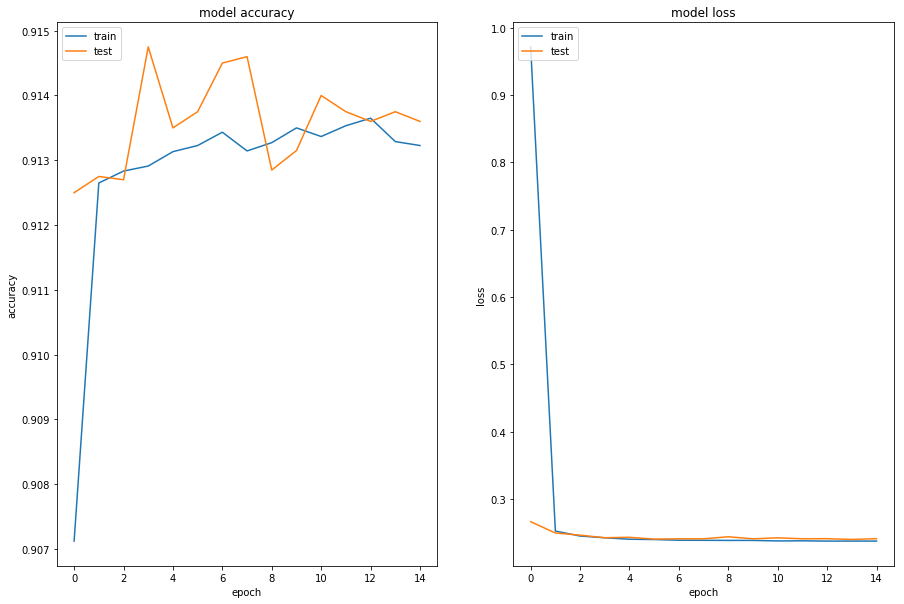

Train AUC:  0.8613921258920845
Vali AUC:  0.8510348618220736


In [48]:
model1 = func_model_reg()
#Para revisar la estructura del modelo, quitar el comentario de la instruccion siguiente:
#print(model1.summary())
train_history_tam1 = model1.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY), verbose=0)
graf_model(train_history_tam1)
precision(model1)

# Resultado Final

Elije una arquitectura de red que te permita tener el valor de AUC mas alto que puedas lograr

 **Ejecuta esta celda 1 sola vez con la arquitectura final elegida en los experimentos anteriores**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 1028)              206628    
_________________________________________________________________
dropout_34 (Dropout)         (None, 1028)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 1028)              1057812   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1028)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 1028)              1057812   
__________

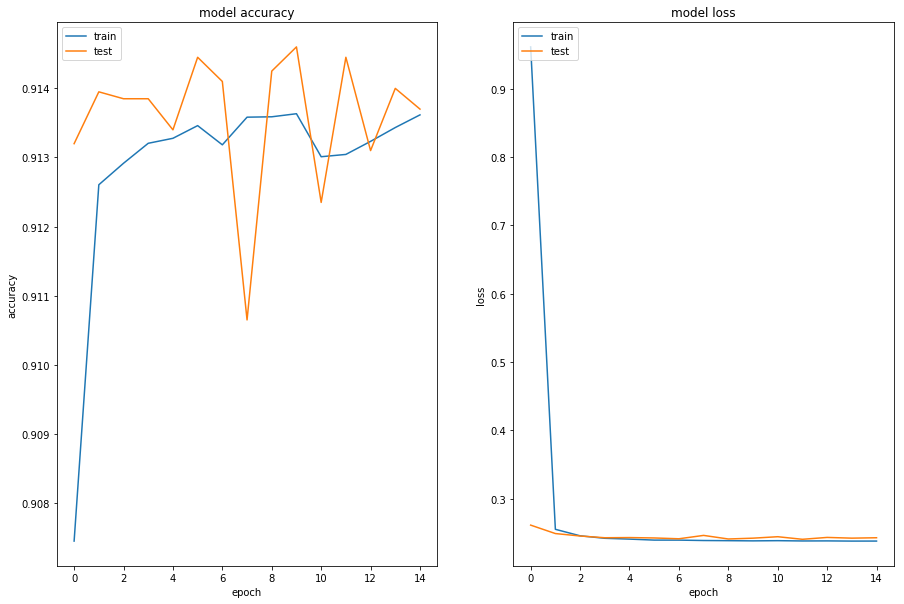

Train AUC:  0.8613650930904113
Vali AUC:  0.8496289121374783


In [49]:
modelRF = func_model_reg()
print(modelRF.summary())
train_history_regF = modelRF.fit(train_dfX, train_dfY, batch_size=512, epochs=epochs, validation_data=(val_dfX, val_dfY))
graf_model(train_history_regF)
precision(modelRF, True)
assert(len(precisiones_globales)==3)

# Modelo Final.

Juega con el modelo y genera el mejor valor de AUC que puedas lograr. 

# Salida de datos.

Con esta celda se exportaran los datos.



In [51]:
y_test = model.predict(test_df)
submission['target'] = y_test
submission.to_csv('TAREA.csv', index=False)